In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask, request, render_template
import joblib

In [2]:
df = pd.read_csv("House Price India.csv ")

In [3]:
df.columns

Index(['id', 'Date', 'number of bedrooms', 'number of bathrooms',
       'living area', 'lot area', 'number of floors', 'waterfront present',
       'number of views', 'condition of the house', 'grade of the house',
       'Area of the house(excluding basement)', 'Area of the basement',
       'Built Year', 'Renovation Year', 'Postal Code', 'Lattitude',
       'Longitude', 'living_area_renov', 'lot_area_renov',
       'Number of schools nearby', 'Distance from the airport', 'Price'],
      dtype='object')

In [4]:
df.drop(['id','number of views','Lattitude', 'Longitude'],axis=1)

,Date,number of bedrooms,number of bathrooms,living area,lot area,number of floors,waterfront present,condition of the house,grade of the house,Area of the house(excluding basement),Area of the basement,Built Year,Renovation Year,Postal Code,living_area_renov,lot_area_renov,Number of schools nearby,Distance from the airport,Price
0,42491,4,2.50,2920,4000,1.5,0,5,8,1910,1010,1909,0,122004,2470,4000,2,51,1400000
1,42491,5,2.75,2910,9480,1.5,0,3,8,2910,0,1939,0,122004,2940,6600,1,53,1200000
2,42491,4,2.50,3310,42998,2.0,0,3,9,3310,0,2001,0,122005,3350,42847,3,76,838000
3,42491,3,2.00,2710,4500,1.5,0,4,8,1880,830,1929,0,122006,2060,4500,1,51,805000
4,42491,3,2.50,2600,4750,1.0,0,4,9,1700,900,1951,0,122007,2380,4750,1,67,790000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14614,42734,2,1.50,1556,20000,1.0,0,4,7,1556,0,1957,0,122066,2250,17286,3,76,221700
14615,42734,3,2.00,1680,7000,1.5,0,4,7,1680,0,1968,0,122072,1540,7480,3,59,219200
14616,42734,2,1.00,1070,6120,1.0,0,3,6,1070,0,1962,0,122056,1130,6120,2,64,209000
14617,42734,4,1.00,1030,6621,1.0,0,4,6,1030,0,1955,0,122042,1420,6631,3,54,205000


In [5]:
def preprocess_data(df):
    df['age_of_house'] = 2025 - df['Built Year']
    df['renovation_age'] = df.apply(lambda row: 2025 - row['Renovation Year'] if row['Renovation Year'] != 0 else 2025 - row['Built Year'], axis=1)
    df['total_area'] = df['living area'] + df['Area of the basement']

    features = ['number of bedrooms', 'number of bathrooms', 'total_area', 'lot area', 'number of floors',
                'waterfront present', 'condition of the house', 'grade of the house', 'age_of_house',
                'renovation_age', 'Number of schools nearby', 'Distance from the airport', 'Postal Code']
    X = df[features]
    y = df['Price']

    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    postal_encoded = encoder.fit_transform(X[['Postal Code']])
    postal_columns = encoder.get_feature_names_out(['Postal Code'])
    postal_df = pd.DataFrame(postal_encoded, columns=postal_columns)

    X_numeric = X.drop('Postal Code', axis=1)
    X_combined = pd.concat([X_numeric, postal_df], axis=1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)

    return X_scaled, y, scaler, encoder, X_combined.columns

In [6]:
def preprocess_input(user_input_df, encoder, scaler, feature_columns):
    user_input_df['age_of_house'] = 2025 - user_input_df['Built Year']
    user_input_df['renovation_age'] = user_input_df.apply(
        lambda row: 2025 - row['Renovation Year'] if row['Renovation Year'] != 0 else 2025 - row['Built Year'],
        axis=1)
    user_input_df['total_area'] = user_input_df['living area'] + user_input_df['Area of the basement']

    features = ['number of bedrooms', 'number of bathrooms', 'total_area', 'lot area', 'number of floors',
                'waterfront present', 'condition of the house', 'grade of the house', 'age_of_house',
                'renovation_age', 'Number of schools nearby', 'Distance from the airport', 'Postal Code']

    X = user_input_df[features]

    postal_encoded = encoder.transform(X[['Postal Code']])
    postal_df = pd.DataFrame(postal_encoded, columns=encoder.get_feature_names_out(['Postal Code']))

    X_numeric = X.drop('Postal Code', axis=1)
    X_combined = pd.concat([X_numeric, postal_df], axis=1)

    X_combined = X_combined.reindex(columns=feature_columns, fill_value=0)

    X_scaled = scaler.transform(X_combined)
    return X_scaled


In [7]:
X_scaled, y, scaler, encoder, feature_columns = preprocess_data(df)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [9]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [10]:
y_pred = rfr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, R²: {r2:.2f}")

RMSE: 158081.99, R²: 0.83


In [11]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['cluster'] = clusters

In [12]:
import os
os.makedirs('static', exist_ok=True)

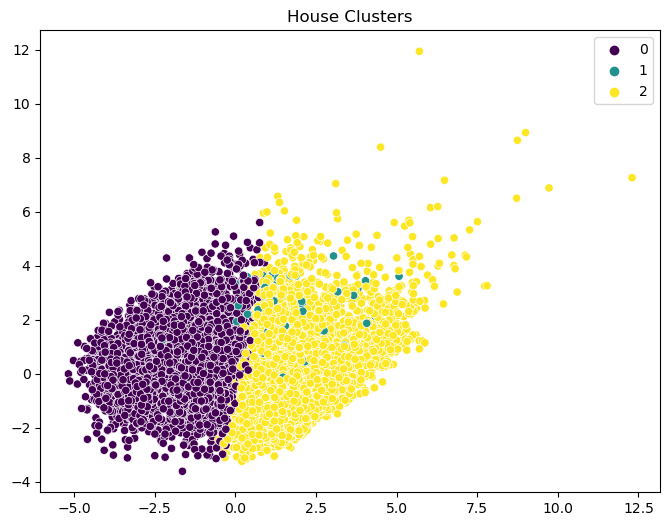

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis')
plt.title('House Clusters')
plt.savefig('static/clusters.png')

In [14]:
joblib.dump(rfr, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')
joblib.dump(kmeans, 'kmeans.pkl')
joblib.dump(feature_columns,'feature_column.pkl')

['feature_column.pkl']